In [50]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import wandb
import matplotlib.pyplot as plt

In [51]:
ticket_symbol = "DAX"

ticker = yf.Ticker(ticket_symbol)

historical_data = ticker.history(period="2y")  # data for last year

print(historical_data)

                                Open       High        Low      Close  Volume  \
Date                                                                            
2023-04-03 00:00:00-04:00  27.951843  28.066126  27.866131  28.066126    7500   
2023-04-04 00:00:00-04:00  28.189935  28.189935  28.066127  28.123270   14300   
2023-04-05 00:00:00-04:00  27.828037  27.985178  27.780420  27.828037   10500   
2023-04-06 00:00:00-04:00  27.828038  28.208984  27.828038  28.132795   10900   
2023-04-10 00:00:00-04:00  27.923275  28.037560  27.923275  28.037560    3600   
...                              ...        ...        ...        ...     ...   
2025-03-26 00:00:00-04:00  40.070000  40.259998  39.479000  39.630001  303900   
2025-03-27 00:00:00-04:00  39.389999  39.769001  39.349998  39.650002  212000   
2025-03-28 00:00:00-04:00  39.529999  39.630001  39.221001  39.419998  139800   
2025-03-31 00:00:00-04:00  38.740002  39.180000  38.529999  39.099998  256300   
2025-04-01 00:00:00-04:00  3


Training data shape: (471, 8)
Test data shape: (30, 8)


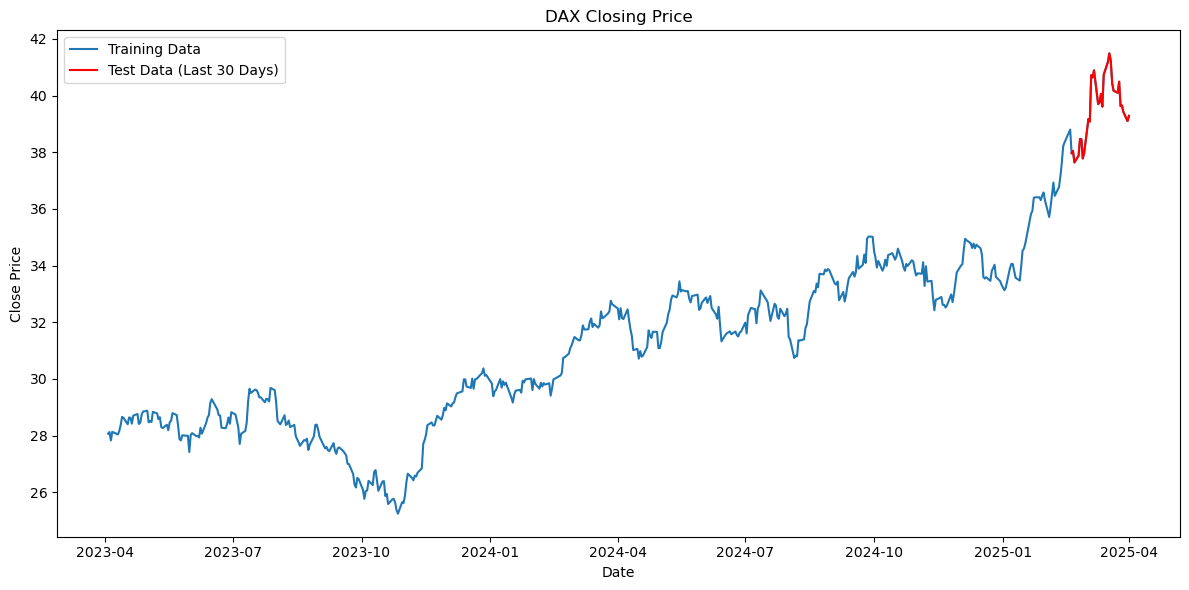

In [52]:
# Get the last month of data as test set (last 30 days)
last_30_days = historical_data[-30:]

train_data = historical_data[:-30]
print(f"\nTraining data shape: {train_data.shape}")
print(f"Test data shape: {last_30_days.shape}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data["Close"])
plt.plot(last_30_days.index, last_30_days["Close"], color="red")
plt.title(f"{ticket_symbol} Closing Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(["Training Data", "Test Data (Last 30 Days)"])
plt.tight_layout()
plt.show()

In [53]:
from sklearn.preprocessing import StandardScaler

columns_to_drop = ["Close"]

X_train = train_data.drop(columns=columns_to_drop)
Y_train = train_data["Close"].shift(-1)

X_test = last_30_days.drop(columns=columns_to_drop)
Y_test = last_30_days["Close"].shift(-1)

X_scaler = StandardScaler()
X_train_norm = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_norm = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

Y_scaler = StandardScaler()
Y_train_norm = pd.Series(
    Y_scaler.fit_transform(Y_train.dropna().values.reshape(-1, 1)).flatten(), index=Y_train.dropna().index, name="Close"
)
Y_test_values = Y_test.dropna().values.reshape(-1, 1)
Y_test_norm = pd.Series(Y_scaler.transform(Y_test_values).flatten(), index=Y_test.dropna().index, name="Close")

/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction resul

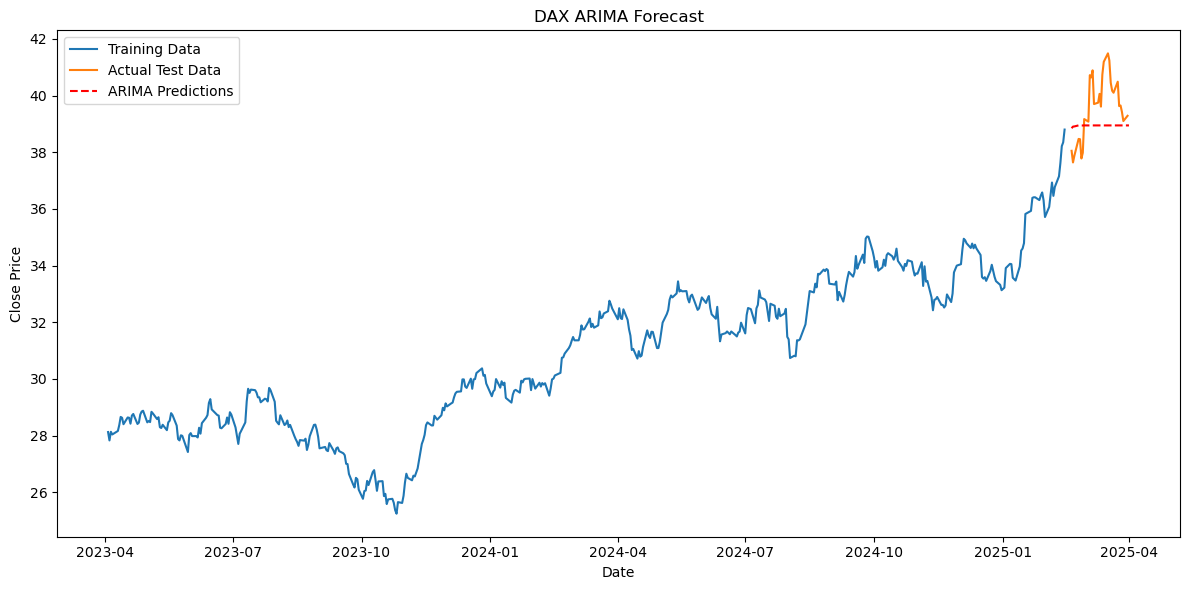

Y_test_clean shape: (29,)
Mean Squared Error: 1.6408
Root Mean Squared Error: 1.2810


In [54]:
Y_train_clean = Y_train.dropna()

model = ARIMA(Y_train_clean, order=(5, 1, 0))
model_fit = model.fit()

#
forecast = model_fit.forecast(steps=30)
pred_dates = Y_test.index
predictions = pd.Series(forecast.to_list(), index=pred_dates)

plt.figure(figsize=(12, 6))
plt.plot(Y_train_clean, label="Training Data")
plt.plot(Y_test, label="Actual Test Data")
plt.plot(predictions, label="ARIMA Predictions", color="red", linestyle="--")
plt.title(f"{ticket_symbol} ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

Y_test_clean = Y_test.dropna()
print(f"Y_test_clean shape: {Y_test_clean.shape}")
predictions_aligned = predictions[Y_test_clean.index]

mse = mean_squared_error(Y_test_clean, predictions_aligned)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.4f}")

/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction resul

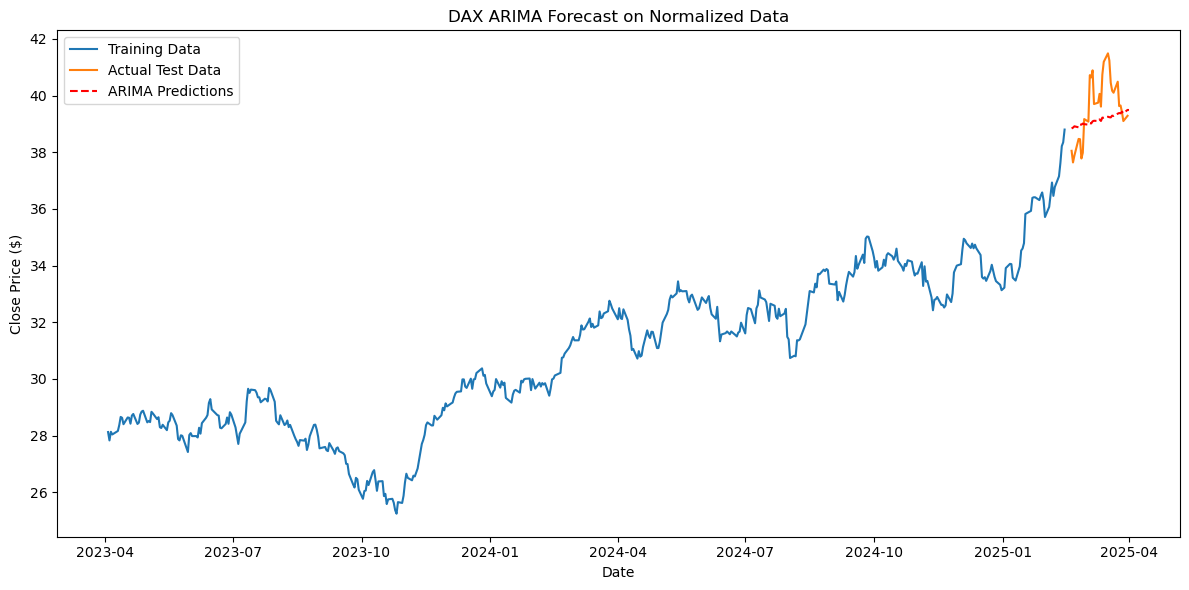

Mean Squared Error: 1.2564
Root Mean Squared Error: 1.1209
Mean Absolute Error: 0.9327
Mean Absolute Percentage Error: 2.33%


In [55]:
model_norm = ARIMA(Y_train_norm.dropna(), order=(5, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit_norm = model_norm.fit()

forecast_norm = model_fit_norm.forecast(steps=30)

forecast_orig = Y_scaler.inverse_transform(forecast_norm.values.reshape(-1, 1)).flatten()
forecast_series = pd.Series(forecast_orig, index=pred_dates)

plt.figure(figsize=(12, 6))
plt.plot(Y_train_clean, label="Training Data")
plt.plot(Y_test, label="Actual Test Data")
plt.plot(forecast_series, label="ARIMA Predictions", color="red", linestyle="--")
plt.title(f"{ticket_symbol} ARIMA Forecast on Normalized Data")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

forecast_aligned = forecast_series[Y_test_clean.index]

mse_norm = mean_squared_error(Y_test_clean, forecast_aligned)
rmse_norm = np.sqrt(mse_norm)
mae_norm = np.mean(np.abs(Y_test_clean - forecast_aligned))

print(f"Mean Squared Error: {mse_norm:.4f}")
print(f"Root Mean Squared Error: {rmse_norm:.4f}")
print(f"Mean Absolute Error: {mae_norm:.4f}")

mape = np.mean(np.abs((Y_test_clean - forecast_aligned) / Y_test_clean)) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

comparison_df = pd.DataFrame(
    {"Actual": Y_test_clean, "Predicted": forecast_aligned, "Difference": Y_test_clean - forecast_aligned}
)

In [56]:
def train_arima_model(config=None):
    """
    Train an ARIMA model with the given configuration and log results to wandb.
    """

    with wandb.init(config=config):
        config = wandb.config

        p, d, q = config.p, config.d, config.q
        P, D, Q, s = config.P, config.D, config.Q, config.s

        print(f"Training ARIMA({p},{d},{q})({P},{D},{Q},{s})")

        try:
            model_norm = ARIMA(Y_train_norm.dropna(), order=(p, d, q), seasonal_order=(P, D, Q, s))
            model_fit_norm = model_norm.fit()

            forecast_norm = model_fit_norm.forecast(steps=len(Y_test))

            forecast_orig = Y_scaler.inverse_transform(forecast_norm.values.reshape(-1, 1)).flatten()
            forecast_series = pd.Series(forecast_orig, index=pred_dates)

            forecast_aligned = forecast_series[Y_test_clean.index]

            mse = mean_squared_error(Y_test_clean, forecast_aligned)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(Y_test_clean - forecast_aligned))
            mape = np.mean(np.abs((Y_test_clean - forecast_aligned) / Y_test_clean)) * 100

            plt.figure(figsize=(10, 6))
            plt.plot(Y_train_clean, label="Training Data")
            plt.plot(Y_test_clean, label="Actual Test Data")
            plt.plot(forecast_aligned, label="ARIMA Predictions", color="red", linestyle="--")
            plt.title(f"{ticket_symbol} ARIMA({p},{d},{q})({P},{D},{Q},{s}) Forecast")
            plt.xlabel("Date")
            plt.ylabel("Close Price ($)")
            plt.legend()
            plt.tight_layout()

            wandb.log(
                {
                    "mse": mse,
                    "rmse": rmse,
                    "mae": mae,
                    "mape": mape,
                    "forecast_plot": wandb.Image(plt),
                    "p": p,
                    "d": d,
                    "q": q,
                    "P": P,
                    "D": D,
                    "Q": Q,
                    "s": s,
                }
            )

            comparison_df = pd.DataFrame(
                {"Actual": Y_test_clean, "Predicted": forecast_aligned, "Difference": Y_test_clean - forecast_aligned}
            )

            wandb.log({"comparison_table": wandb.Table(dataframe=comparison_df)})

            plt.close()

            print(f"Completed run with MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

            return mse

        except Exception as e:
            print(f"Error training model with config {config}: {str(e)}")
            wandb.log({"error": str(e)})
            return float("inf")

In [57]:
%%capture

sweep_configuration = {
    "method": "bayes", 
    "metric": {"name": "mse", "goal": "minimize"},
    "parameters": {
        "p": {"values": [0, 1, 2, 3, 4, 5]},
        "d": {"values": [0, 1, 2]}, 
        "q": {"values": [0, 1, 2, 3, 4, 5]},  
        "P": {"values": [0, 1, 2]},
        "D": {"values": [0, 1]}, 
        "Q": {"values": [0, 1, 2]}, 
        "s": {"values": [12]},  
    },
}

PROJECT_NAME = "stock-forecast"

wandb.login()
sweep_id = wandb.sweep(sweep_configuration, project=PROJECT_NAME)

wandb.agent(sweep_id, function=train_arima_model, count=20)  # Run 20 with bayesian optimization


wandb: Sorting runs by +summary_metrics.mse


Best configuration found:
ARIMA(5,0,5)(2,0,0,12)
Best MSE: 0.9026


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/filippatyk/miniforge3/envs/uam/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramet


Final Model Performance:
Mean Squared Error: 0.9026
Root Mean Squared Error: 0.9501
Mean Absolute Error: 0.7847
Mean Absolute Percentage Error: 1.97%

Comparison of Actual vs Predicted values:
                              Actual  Predicted  Difference
Date                                                       
2025-02-19 00:00:00-05:00  38.049999  38.779626   -0.729627
2025-02-20 00:00:00-05:00  37.639999  38.652143   -1.012144
2025-02-21 00:00:00-05:00  37.880001  38.705581   -0.825580
2025-02-24 00:00:00-05:00  38.470001  38.932846   -0.462845
2025-02-25 00:00:00-05:00  38.459999  39.493935   -1.033936
2025-02-26 00:00:00-05:00  37.779999  39.075418   -1.295419
2025-02-27 00:00:00-05:00  37.980000  39.299589   -1.319590
2025-02-28 00:00:00-05:00  39.169998  39.402724   -0.232726
2025-03-03 00:00:00-05:00  39.080002  39.474426   -0.394424
2025-03-04 00:00:00-05:00  40.720001  39.626028    1.093973
2025-03-05 00:00:00-05:00  40.639999  39.655729    0.984270
2025-03-06 00:00:00-05:00 

final_mae,▁
final_mape,▁
final_mse,▁
final_rmse,▁
final_mae,0.78469
final_mape,1.97348
final_mse,0.90263
final_rmse,0.95007


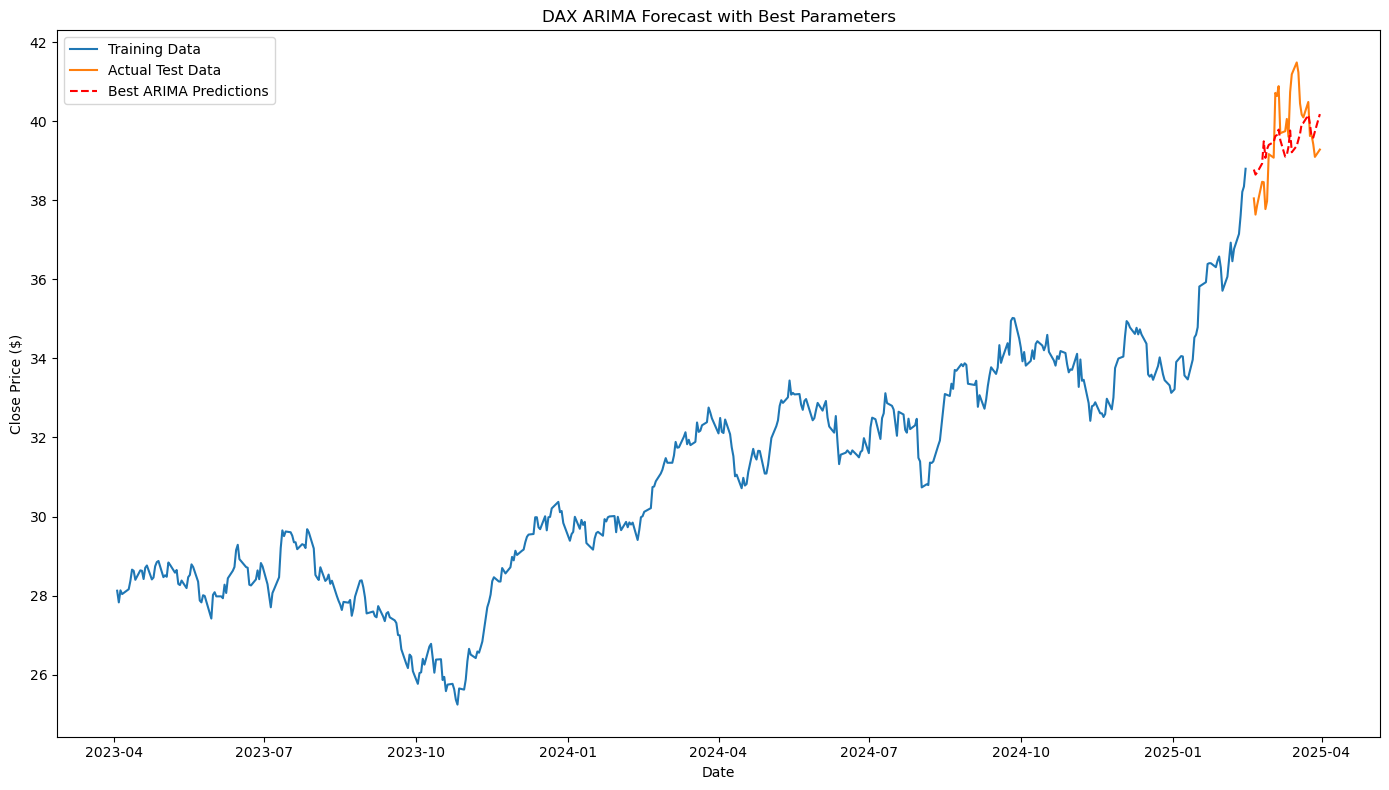

In [59]:
# Get the best run from the sweep
api = wandb.Api()
entity = api.default_entity
sweep = api.sweep(f"{entity}/{PROJECT_NAME}/{sweep_id}")
best_run = sweep.best_run()

print("Best configuration found:")
best_config = best_run.config
print(
    f"ARIMA({best_config['p']},{best_config['d']},{best_config['q']})({best_config['P']},{best_config['D']},{best_config['Q']},{best_config['s']})"
)
print(f"Best MSE: {best_run.summary['mse']:.4f}")

final_config = {
    "p": best_config["p"],
    "d": best_config["d"],
    "q": best_config["q"],
    "P": best_config["P"],
    "D": best_config["D"],
    "Q": best_config["Q"],
    "s": best_config["s"],
}

with wandb.init(project=PROJECT_NAME, name="final_model"):
    model_norm = ARIMA(
        Y_train_norm.dropna(),
        order=(final_config["p"], final_config["d"], final_config["q"]),
        seasonal_order=(final_config["P"], final_config["D"], final_config["Q"], final_config["s"]),
    )
    model_fit_norm = model_norm.fit()

    forecast_norm = model_fit_norm.forecast(steps=len(Y_test))

    forecast_orig = Y_scaler.inverse_transform(forecast_norm.values.reshape(-1, 1)).flatten()
    forecast_series = pd.Series(forecast_orig, index=pred_dates)

    plt.figure(figsize=(14, 8))
    plt.plot(Y_train_clean, label="Training Data")
    plt.plot(Y_test_clean, label="Actual Test Data")
    plt.plot(forecast_series[Y_test_clean.index], label="Best ARIMA Predictions", color="red", linestyle="--")
    plt.title(f"{ticket_symbol} ARIMA Forecast with Best Parameters")
    plt.xlabel("Date")
    plt.ylabel("Close Price ($)")
    plt.legend()
    plt.tight_layout()

    wandb.log({"final_forecast_plot": wandb.Image(plt)})

    forecast_aligned = forecast_series[Y_test_clean.index]
    mse = mean_squared_error(Y_test_clean, forecast_aligned)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(Y_test_clean - forecast_aligned))
    mape = np.mean(np.abs((Y_test_clean - forecast_aligned) / Y_test_clean)) * 100

    wandb.log({"final_mse": mse, "final_rmse": rmse, "final_mae": mae, "final_mape": mape})

    print("\nFinal Model Performance:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")

    comparison_df = pd.DataFrame(
        {"Actual": Y_test_clean, "Predicted": forecast_aligned, "Difference": Y_test_clean - forecast_aligned}
    )

    print("\nComparison of Actual vs Predicted values:")
    print(comparison_df)

    wandb.log({"final_comparison_table": wandb.Table(dataframe=comparison_df)})

    model_artifact = wandb.Artifact(
        name="arima_best_model",
        type="model",
        description=f"ARIMA({final_config['p']},{final_config['d']},{final_config['q']})"
        f"({final_config['P']},{final_config['D']},{final_config['Q']},{final_config['s']})",
    )
    wandb.log_artifact(model_artifact)
    wandb.finish()